# CoTA: Compression Transformer Autoencoder


CoTA introduces a novel approach to representing sequential data. Instead of relying on a single vector, CoTA utilizes a variable number of embedding vectors. This method enhances the preservation of details and maintains the order more effectively.





| ![bert_encoder.png](readme/images/bert_encoder.png) | ![cot_encoder.png](readme/images/cot_encoder.png) |
|:------------------------------------------------------:|:----------------------------------------------------:|
|                    Typical encoder                     |                     CoTA encoder                     |

In [2]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

from src.autoencoder.config import Config
from src.autoencoder.inference import inference, get_memory
from src.autoencoder.model import Model as CoTA
from src.autoencoder.viz import viz
from src.classifier.model import Classifier
from src.shapT5 import shap_values
from src.util import prepare

# Preparations

In [3]:
prepare.rnd(Config.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(Config.model)

In [4]:
examples = (
	"Very disappointed in the customer service. We ordered Reuben's and wanted coleslaw instead of kraut. They charged us $3.00 for the coleslaw. We will not be back . The iced tea is also terrible tasting.",

	"This place is so nice! The dishes are delicious. I especially recommend trying beef stroganoff!",
)

# Inference


In [8]:
ckpt = "checkpoint/29249.pth"
checkpoint = torch.load(ckpt, weights_only=True, map_location=device)

cota_model = CoTA(Config.model, Config.bias, Config.temperature).to(device)
cota_model.load_state_dict(checkpoint["model"])
cota_model.eval();

In [12]:
inference(cota_model, tokenizer, examples[0])

Initial length: 52
Compression rate: 0.23
Output size: 12

Initial text:
Very disappointed in the customer service. We ordered Reuben's and wanted coleslaw instead of kraut. They charged us $3.00 for the coleslaw. We will not be back . The iced tea is also terrible tasting.
Predicted:
Very disappointed in the customer service. We ordered Reuben's and wanted coleslaw instead of kraut. They charged us $3.00 for the coleslaw. I won't be back. The iced tea is also terrible tasting.


# Sentiment Classification

In [13]:
classifier = Classifier()
classifier = classifier.to(device)

init = "checkpoint/1_classifier.pth"
init = torch.load(init, map_location=device, weights_only=True)
classifier.load_state_dict(init)
classifier.eval();

In [14]:
def classify(compressed_seq):
	with torch.no_grad():
		embeds = compressed_seq.embeds.squeeze(0)
		index = torch.tensor([0] * len(embeds), dtype=torch.long).to(device)
		logits = classifier.forward(embeds, index)

	prob = torch.sigmoid(logits).item()
	sentiment = "Positive" if prob > 0.5 else "Negative"
	prob = prob if sentiment == "Positive" else 1.0 - prob
	print(f"\nSentiment: {sentiment} ({prob:.2%} confidence)")

In [15]:
def demo(text):
	inference(cota_model, tokenizer, text)
	viz(cota_model, tokenizer, text)

	compressed_seq = get_memory(cota_model, tokenizer, text, device, return_tokens=False)
	classify(compressed_seq)

demo(examples[1])

Initial length: 22
Compression rate: 0.14
Output size: 3

Initial text:
This place is so nice! The dishes are delicious. I especially recommend trying beef stroganoff!
Predicted:
This place is so nice! The food is delicious. And the portions are great for dessert strogano!
Layer 0:
No compression in this layer!

Layer 1:
- Eliminated token: '▁place', (position: 1)
		1. Merged into '</s>' (score: 0.4648)
		2. Merged into '▁This' (score: 0.2420)
		3. Merged into '!' (score: 0.0897)
- Eliminated token: '▁is', (position: 2)
		1. Merged into '</s>' (score: 0.4989)
		2. Merged into '▁This' (score: 0.2224)
		3. Merged into '▁place' (score: 0.0801)
- Eliminated token: '▁so', (position: 3)
		1. Merged into '</s>' (score: 0.4354)
		2. Merged into '▁is' (score: 0.1678)
		3. Merged into '▁This' (score: 0.0901)
- Eliminated token: '▁The', (position: 6)
		1. Merged into '</s>' (score: 0.5865)
		2. Merged into '!' (score: 0.0765)
		3. Merged into '▁nice' (score: 0.0764)
- Eliminated token: '▁are', (p

## Mask

In [10]:
def plot_matrix(matrix, figsize, title):
	matrix_for_plot = np.where(np.isneginf(matrix), -1, matrix)
	plt.figure(figsize=figsize)
	sns.heatmap(matrix_for_plot, annot=True, cmap="rocket_r", cbar=False)
	plt.title(title)
	plt.xticks(rotation=90)
	plt.show()


def plot_masks(memory):
	gate_mask = torch.exp(memory.gate_mask.detach().cpu()).numpy()
	plot_matrix(gate_mask, (20, 1), "Gate Mask")

	attn_mask = memory.attn_scores[-1].detach().cpu().numpy()
	matrix = attn_mask.mean(0)
	plot_matrix(matrix, (16, 16), "Last layer Attention Mask")

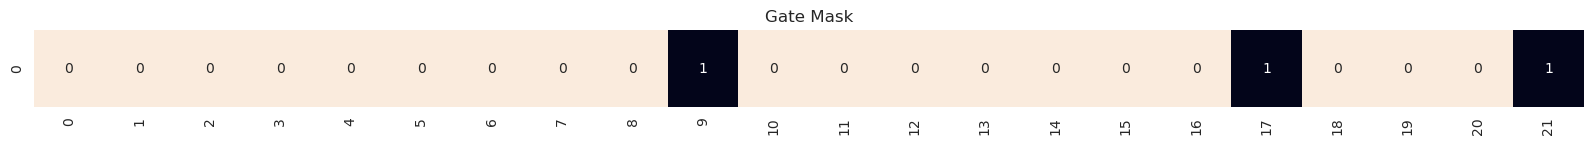

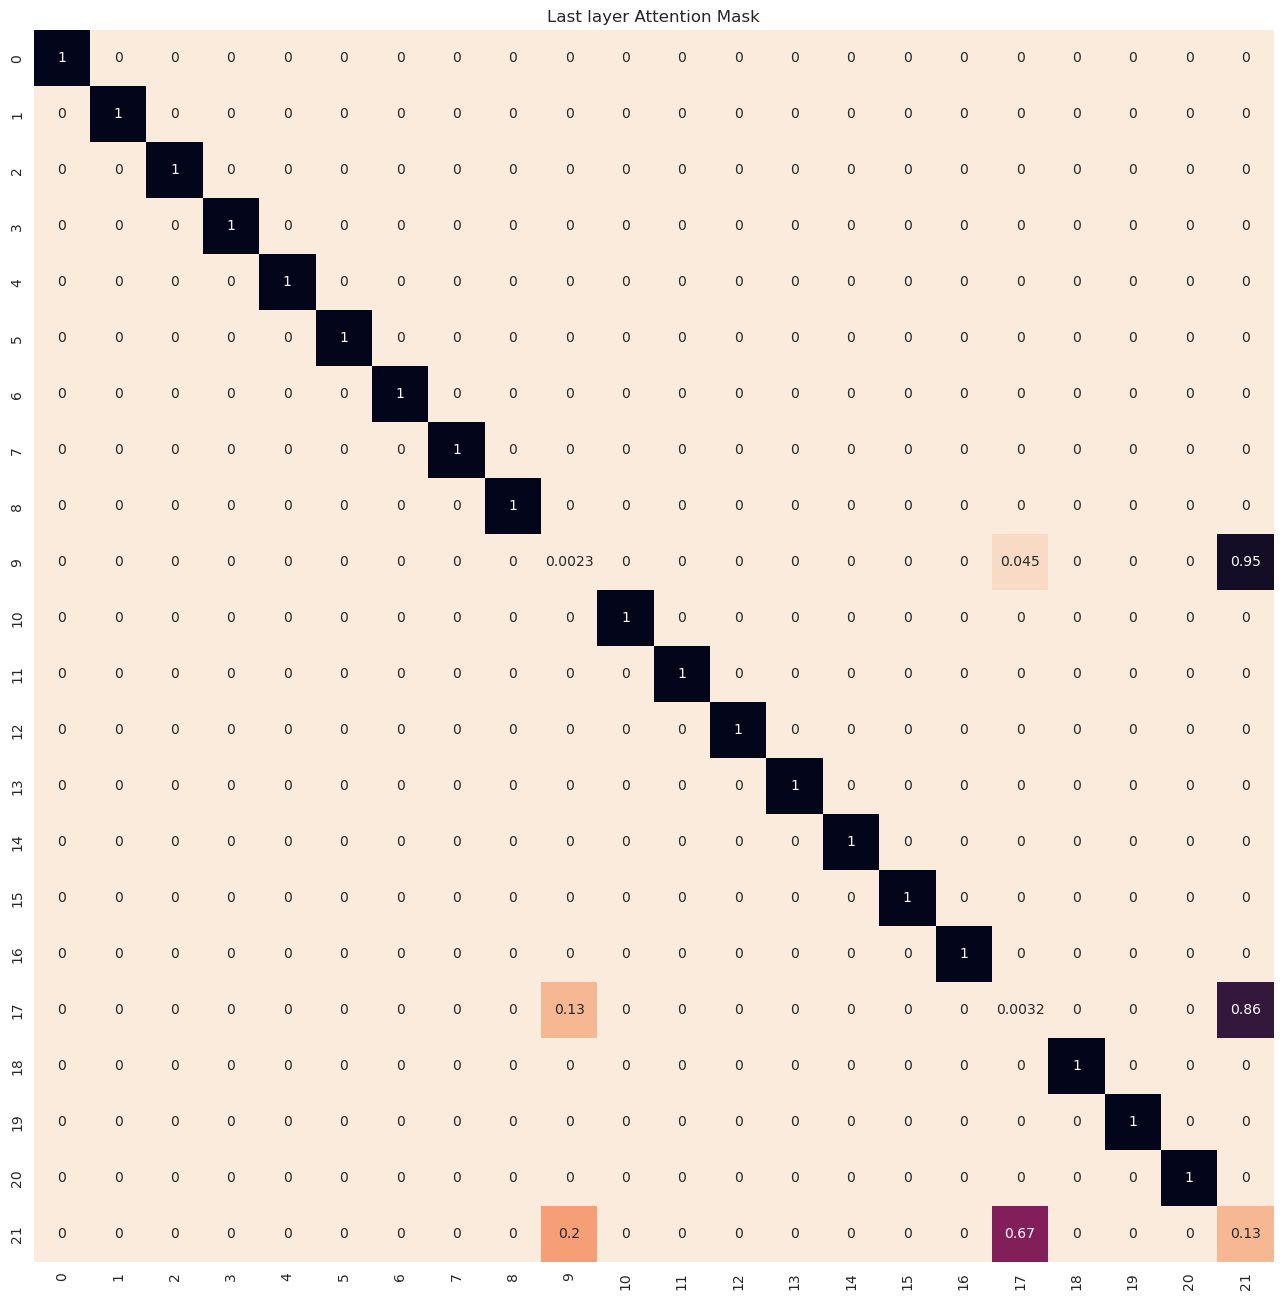

In [11]:
compressed_seq = get_memory(cota_model, tokenizer, examples[1], device, return_tokens=False)
plot_masks(compressed_seq)

## SHAP

In [ ]:
shap_values(examples[0], 32)

# Interactive Mode

In [ ]:
def interactive():
	print("\n--- CoTA Interactive Demo ---")
	print("Type 'exit' to end the session\n")

	while True:
		text = input("> ")
		if text.lower() == 'exit':
			break

		if not text.lower():
			print("Incorrect input!")
			continue

		inference(cota_model, tokenizer, text)
		classify(text)
		print("-" * 50)

interactive()